# Constructing a WCS for Overlappogram Data

In [1]:
import numpy as np
import astropy.units as u
from scipy.io import readsav
import sys
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize,LogStretch
import sunpy.map
from sunpy.coordinates import get_earth
sys.path.append('../scripts')
from util import (make_moxsi_ndcube, 
                  construct_overlappogram, 
                  apply_dispersion_shift, 
                  overlap_arrays, 
                  color_lat_lon_axes)

In [2]:
norm=ImageNormalize(vmin=0,vmax=1e2,stretch=LogStretch())
cmap='hinodexrt'
plot_props = {'cmap':cmap, 'norm':norm}

From the `PCi_j` formalism, the conversion between intermediate world coordinates and pixel coordinates is given by (from Gei

$$
x_i = s_iq_i \\
q_i = m_{ij}(p_j - r_j)
$$

The resulting `PC_ij` matrix for our overlappogram **assuming that the dispersion direction is aligned with the y-like pixel axis**,

$$
\begin{bmatrix}
\cos\alpha & \sin\alpha & -\mu\sin\alpha \\
-\sin\alpha & \cos\alpha & -\mu\cos\alpha \\
0 & 0 & 1
\end{bmatrix}
$$

First, load the data into a spectral cube, where each slice represents a different wavelength.

In [3]:
savdata = readsav('../data/forDan_MOXSI_DATA_09112020_0440_feldman.sav')

In [4]:
moxsi_cube = make_moxsi_ndcube(savdata['moxsi1_img'],savdata['cubixss_wave']*u.angstrom)

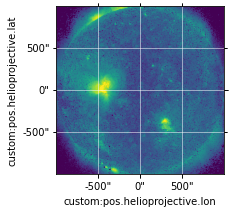

In [5]:
plt.figure(figsize=(3,8))
ax = moxsi_cube[1073//2].plot(norm=ImageNormalize(vmin=0,vmax=1,stretch=LogStretch()))
lon,lat = ax.coords
lon.grid(color='white', alpha=1, linestyle='solid', lw=.5,)
lat.grid(color='white', alpha=1, linestyle='solid', lw=.5,)

We can then flatten this to an overlappogram, specifying the roll angle (angle between the pixel and world axes, where 0 corresponds to the y-like pixel axis aligned with latitude) and spectral order.

In [6]:
observer = get_earth()

In [7]:
moxsi_overlap = construct_overlappogram(moxsi_cube, angle=0*u.deg, observer=observer, order=1,
                                        correlate_p12_with_wave=False)

In [13]:
moxsi_overlap.wcs.axis_correlation_matrix

array([[ True,  True,  True],
       [ True,  True,  True],
       [False,  True, False]])

We can then plot the overlappogram at a few different "wavelength slices." Note as we move in wavelength space, our latitude grid shifts along the dispersion axis.

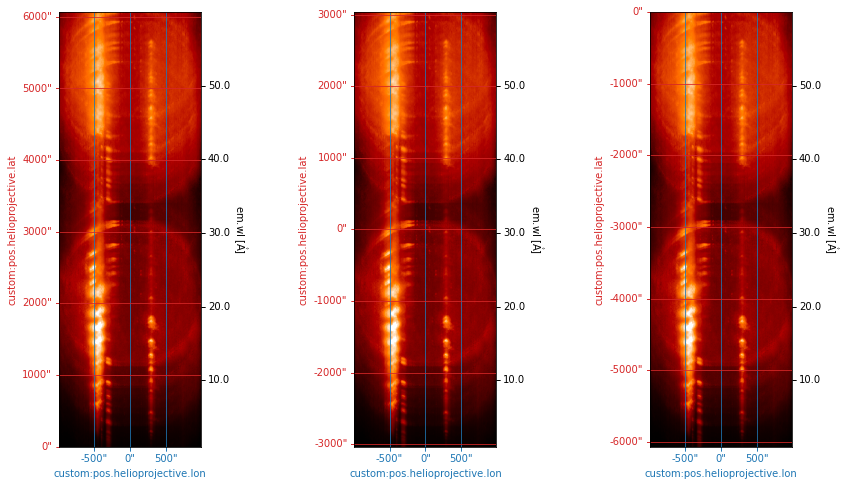

In [15]:
fig = plt.figure(figsize=(15,8))
wvl_indices = [0,1073//2,1072]
for i,iw in enumerate(wvl_indices):
    ax = fig.add_subplot(1,len(wvl_indices),i+1, projection=moxsi_overlap[iw].wcs)
    moxsi_overlap[iw].plot(axes=ax,**plot_props)
    _ = color_lat_lon_axes(ax,lat_tick_ops={'spacing':1000*u.arcsec})
    ax.coords[2].set_format_unit(u.angstrom)
    ax.coords[2].set_major_formatter('x.x')

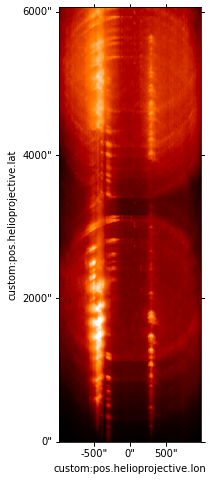

In [25]:
plt.figure(figsize=(3,8))
ax = moxsi_overlap[0].plot(**plot_props)
#ax.coords[2].set_format_unit(u.angstrom)
#ax.coords[2].set_major_formatter('x.x')

We can also choose to orient the pixel (and thus the dispersion) axis at some non-zero angle relative to the world axes.

In [11]:
moxsi_overlap = construct_overlappogram(moxsi_cube, angle=45*u.deg, observer=observer, order=1)

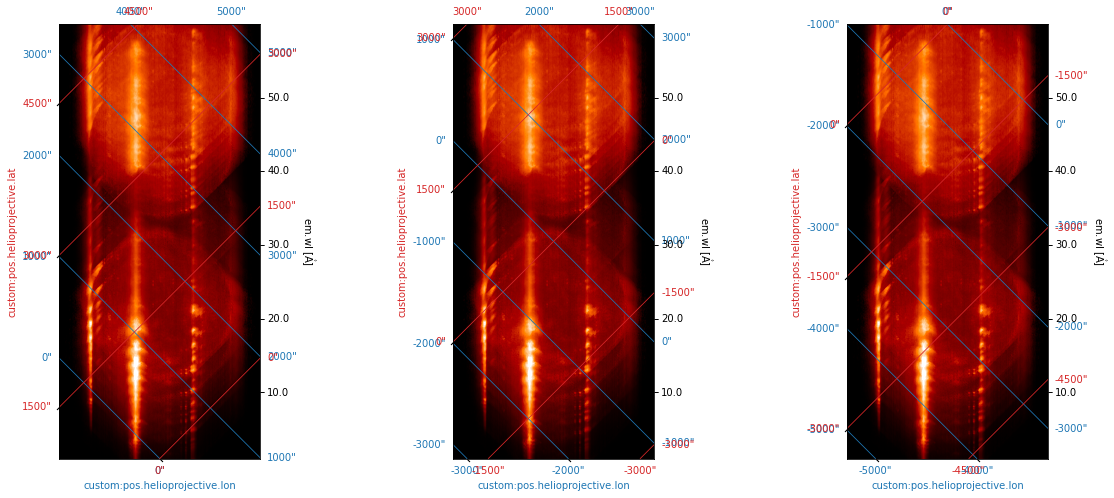

In [15]:
fig = plt.figure(figsize=(20,8))
wvl_indices = [0,1073//2,1072]
for i,iw in enumerate(wvl_indices):
    ax = fig.add_subplot(1,len(wvl_indices),i+1, projection=moxsi_overlap[iw].wcs)
    moxsi_overlap[iw].plot(axes=ax,**plot_props)
    lon,lat = color_lat_lon_axes(ax,
                                 lon_tick_ops={'spacing':1000*u.arcsec},
                                 lat_tick_ops={'spacing':1500*u.arcsec})
    ax.coords[2].set_format_unit(u.angstrom)
    ax.coords[2].set_major_formatter('x.x')

Or completely in the "longitude" direction

In [51]:
moxsi_overlap = construct_overlappogram(moxsi_cube, angle=90*u.deg, observer=observer, order=1)

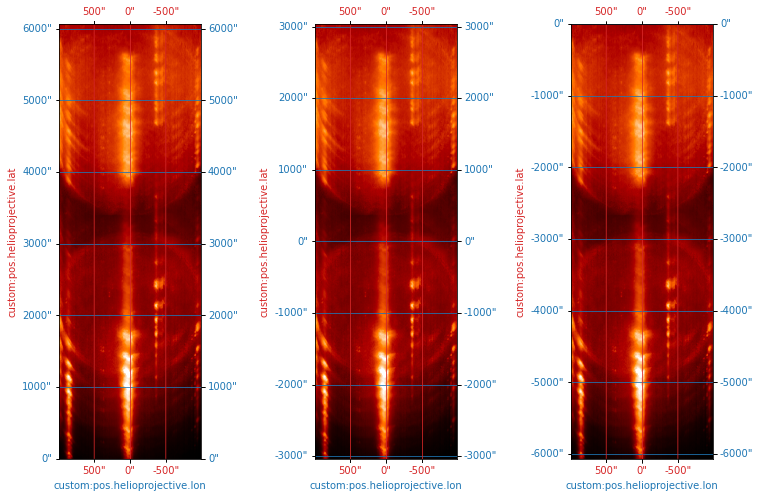

In [52]:
fig = plt.figure(figsize=(13,8))
wvl_indices = [0,1073//2,1072]
for i,iw in enumerate(wvl_indices):
    ax = fig.add_subplot(1,len(wvl_indices),i+1, projection=moxsi_overlap[iw].wcs)
    moxsi_overlap[iw].plot(axes=ax,**plot_props)
    _ = color_lat_lon_axes(ax,lon_tick_ops={'spacing':1000*u.arcsec})

What if we change the order?

In [53]:
m1 = construct_overlappogram(moxsi_cube,angle=0*u.deg,order=1,observer=observer)
m3 = construct_overlappogram(moxsi_cube,angle=0*u.deg,order=3,observer=observer)

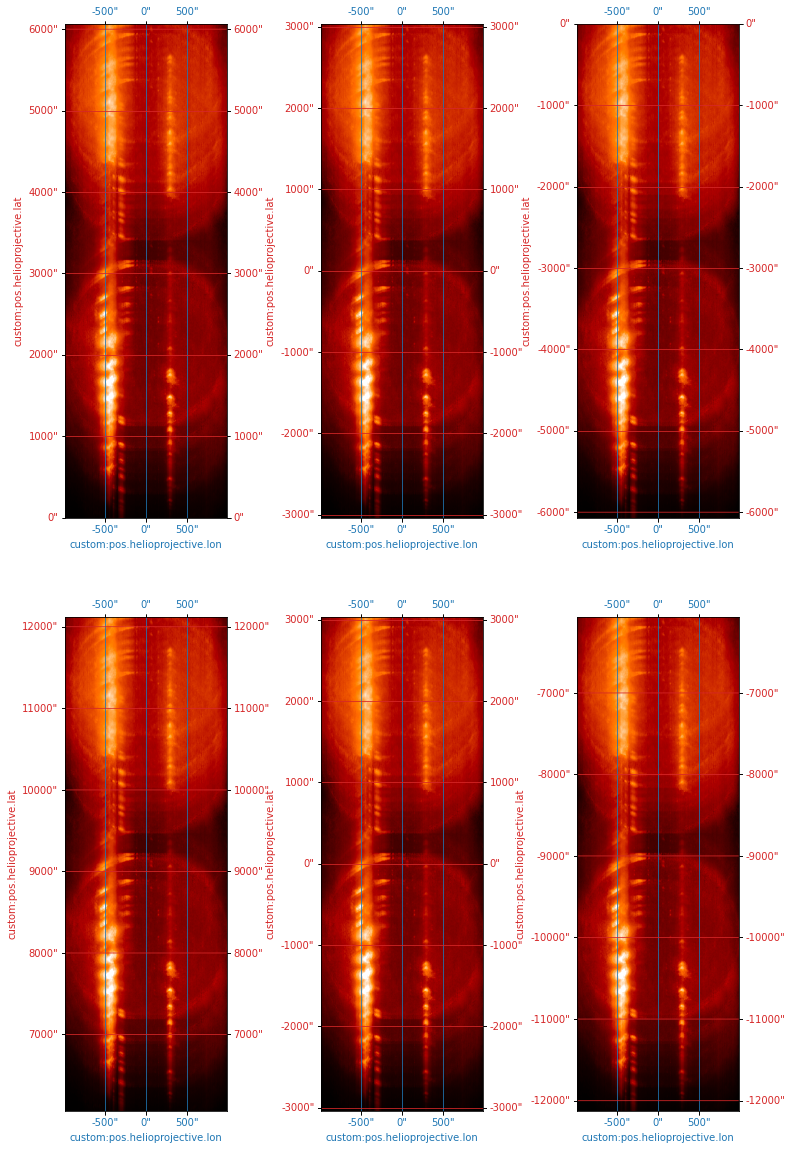

In [58]:
fig = plt.figure(figsize=(13,20))
wvl_indices = [0,1073//2,1072]
for i,iw in enumerate(wvl_indices):
    ax = fig.add_subplot(2,len(wvl_indices),i+1, projection=m1[iw].wcs)
    m1[iw].plot(axes=ax,**plot_props)
    _ = color_lat_lon_axes(ax,lat_tick_ops={'spacing':1000*u.arcsec})
for i,iw in enumerate(wvl_indices):
    ax = fig.add_subplot(2,len(wvl_indices),len(wvl_indices)+i+1, projection=m3[iw].wcs)
    m3[iw].plot(axes=ax,**plot_props)
    _ = color_lat_lon_axes(ax,lat_tick_ops={'spacing':1000*u.arcsec})

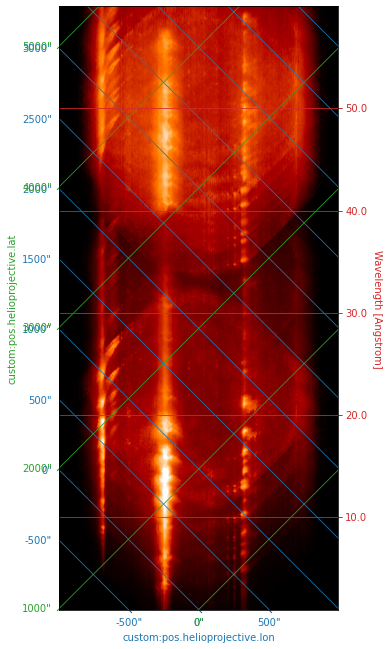

In [42]:
fig = plt.figure(figsize=(5,15))
ax = fig.add_subplot(111, projection=moxsi_overlap[0].wcs)
moxsi_overlap[0].plot(axes=ax,**plot_props)
lon,lat = color_lat_lon_axes(ax,
                             lat_color='C2',
                             lon_tick_ops={'spacing':500*u.arcsec},
                             lat_tick_ops={'spacing':1000*u.arcsec})
ax.coords[2].set_format_unit(u.angstrom)
ax.coords[2].set_major_formatter('x.x')
ax.coords[2].set_ticklabel(color='C3')
ax.coords[2].set_ticks(color='C3')
ax.coords[2].set_axislabel('Wavelength [Angstrom]',color='C3')
ax.coords[2].grid(color='C3',grid_type='contours')

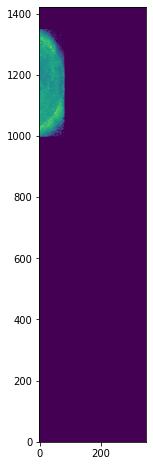

In [44]:
start_row = 1072
foo = apply_dispersion_shift(
    30*u.deg,
    moxsi_cube.data[1073//2]/moxsi_cube.data[1073//2].max(),  # fixing this for testing purposes
    (int(moxsi_cube.data.shape[0] + moxsi_cube.data.shape[1]),moxsi_cube.data.shape[2]),
    start_row,
    start_row+moxsi_cube.data.shape[1],
)
plt.figure(figsize=(3,8))
plt.imshow(foo,origin='lower',norm=ImageNormalize(vmin=0,vmax=.1,stretch=LogStretch()))

In [10]:
foo = overlap_arrays(moxsi_cube, roll_angle=30*u.deg,dispersion_angle=10*u.deg)

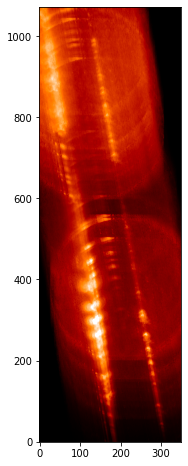

In [11]:
plt.figure(figsize=(3,8))
plt.imshow(foo,**plot_props,origin='lower')

In [7]:
moxsi_overlap = construct_overlappogram(
    moxsi_cube, 
    roll_angle=45*u.deg,
    dispersion_angle=10*u.deg,
    observer=observer, 
    order=1,
    correlate_p12_with_wave=True,
)

In [9]:
moxsi_overlap_d0 = construct_overlappogram(
    moxsi_cube, 
    roll_angle=45*u.deg,
    dispersion_angle=0*u.deg,
    observer=observer, 
    order=1,
    correlate_p12_with_wave=True,
)

In [11]:
moxsi_overlap_a0_d5 = construct_overlappogram(
    moxsi_cube, 
    roll_angle=0*u.deg,
    dispersion_angle=5*u.deg,
    observer=observer, 
    order=1,
    correlate_p12_with_wave=True,
)

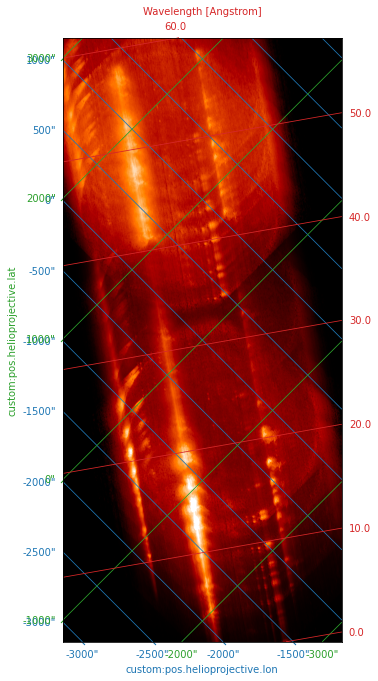

In [8]:
fig = plt.figure(figsize=(5,15))
ax = fig.add_subplot(111, projection=moxsi_overlap[1073//2].wcs)
moxsi_overlap[1073//2].plot(axes=ax,**plot_props)
lon,lat = color_lat_lon_axes(ax,
                             lat_color='C2',
                             lon_tick_ops={'spacing':500*u.arcsec},
                             lat_tick_ops={'spacing':1000*u.arcsec})
ax.coords[2].set_ticklabel_position('rt')
ax.coords[2].set_format_unit(u.angstrom)
ax.coords[2].set_major_formatter('x.x')
ax.coords[2].set_ticklabel(color='C3')
ax.coords[2].set_ticks(color='C3')
ax.coords[2].set_axislabel('Wavelength [Angstrom]',color='C3')
ax.coords[2].grid(color='C3',grid_type='contours')

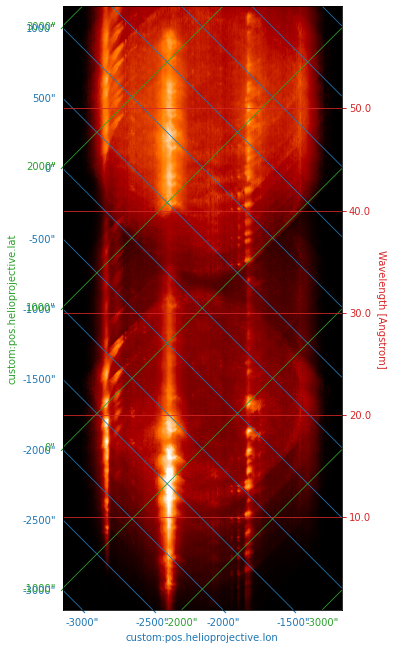

In [10]:
fig = plt.figure(figsize=(5,15))
ax = fig.add_subplot(111, projection=moxsi_overlap_d0[1073//2].wcs)
moxsi_overlap_d0[1073//2].plot(axes=ax,**plot_props)
lon,lat = color_lat_lon_axes(ax,
                             lat_color='C2',
                             lon_tick_ops={'spacing':500*u.arcsec},
                             lat_tick_ops={'spacing':1000*u.arcsec})
ax.coords[2].set_ticklabel_position('rt')
ax.coords[2].set_format_unit(u.angstrom)
ax.coords[2].set_major_formatter('x.x')
ax.coords[2].set_ticklabel(color='C3')
ax.coords[2].set_ticks(color='C3')
ax.coords[2].set_axislabel('Wavelength [Angstrom]',color='C3')
ax.coords[2].grid(color='C3',grid_type='contours')

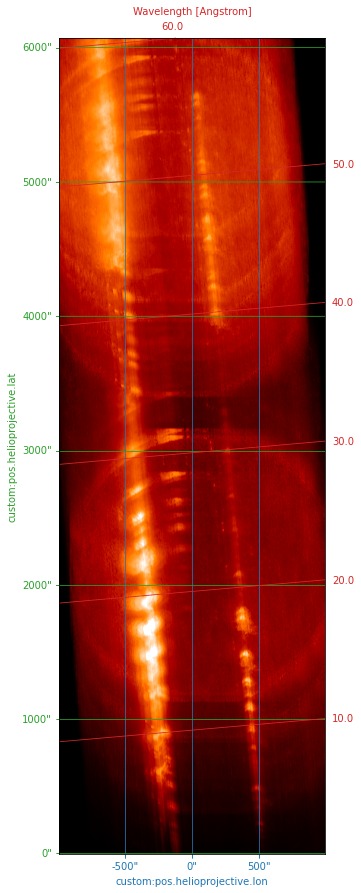

In [13]:
fig = plt.figure(figsize=(5,15))
ax = fig.add_subplot(111, projection=moxsi_overlap_a0_d5[0].wcs)
moxsi_overlap_a0_d5[0].plot(axes=ax,**plot_props)
lon,lat = color_lat_lon_axes(ax,
                             lat_color='C2',
                             lon_tick_ops={'spacing':500*u.arcsec},
                             lat_tick_ops={'spacing':1000*u.arcsec})
ax.coords[2].set_ticklabel_position('rt')
ax.coords[2].set_format_unit(u.angstrom)
ax.coords[2].set_major_formatter('x.x')
ax.coords[2].set_ticklabel(color='C3')
ax.coords[2].set_ticks(color='C3')
ax.coords[2].set_axislabel('Wavelength [Angstrom]',color='C3')
ax.coords[2].grid(color='C3',grid_type='contours')